In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Flatten
import matplotlib.pyplot as plt

# Dataset
The dataset contains `inputs` and `labels`.<br>
**inputs** _(list)_: Represents a slice of a spectrum with a window size of 20.<br>
**labels** _(bool)_: Indicates whether the slice contains a peak (1 for peak presence, 0 for absence)

In [2]:
with open('data/dataset.json', 'r') as fp:
    data = json.load(fp)
    inputs = np.array(data['inputs'])
    labels = np.array(data['labels'])

## Example plots
The plot below demostrates examples from the dataset by:<br>
- Plotting a spectrum containing a peak.<br>
- Plotting a spectrum without a peak.

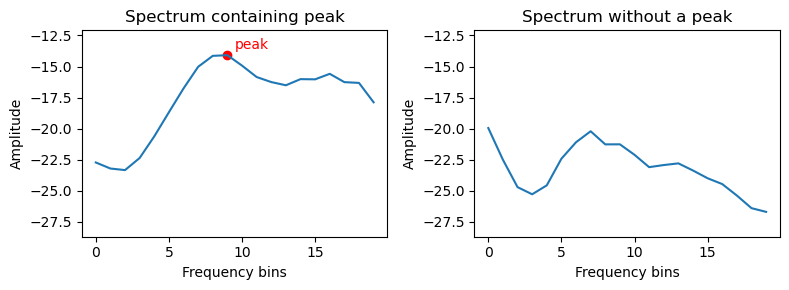

In [3]:
plt.figure(figsize=(8, 3))
y_min = min(min(inputs[7]), min(inputs[9])) - 2
y_max = max(max(inputs[7]), max(inputs[9])) + 2
peak_idx = np.argmax(inputs[7])
peak_mag = inputs[7][peak_idx]

# Spectrum containing a peak
plt.subplot(1, 2, 1)
plt.title('Spectrum containing peak')
plt.xlabel('Frequency bins')
plt.ylabel('Amplitude')
plt.plot(inputs[7])
plt.ylim(y_min, y_max)
plt.scatter(peak_idx, peak_mag, c='r')
plt.text(peak_idx + 0.5, peak_mag + 0.5, f'peak', c='r')

# Spectrum without a peak
plt.subplot(1, 2, 2)
plt.title('Spectrum without a peak')
plt.xlabel('Frequency bins')
plt.ylabel('Amplitude')
plt.plot(inputs[9])
plt.ylim(y_min, y_max)

plt.tight_layout()

## Data augmentation
The dataset requires augmentation to encompass various magnitude ranges and bandwidths.
To achieve this, the following operations can be performed on the dataset:<br>
- shifting
- scaling

### Shifting
Shifting is performed by adding an `offset` to the spectrum.

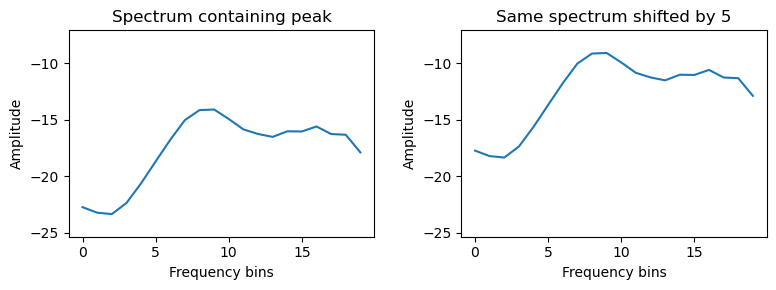

In [4]:
plt.figure(figsize=(8, 3))
y_min = min(inputs[7]) - 2
y_max = max(inputs[7]) + 2 + 5

# Spectrum containing a peak
plt.subplot(1, 2, 1)
plt.title('Spectrum containing peak')
plt.xlabel('Frequency bins')
plt.ylabel('Amplitude')
plt.plot(inputs[7])
plt.ylim(y_min, y_max)

# Same spectrum shifted by 5
plt.subplot(1, 2, 2)
plt.title('Same spectrum shifted by 5')
plt.xlabel('Frequency bins')
plt.ylabel('Amplitude')
plt.plot(inputs[7] + 5)
plt.ylim(y_min, y_max)

plt.tight_layout()

In [5]:
shifted = []
shifted_labels = []

for offset in range(-10, 10):
    for i in range(len(inputs)):
        shifted.append(inputs[i] + offset)
        shifted_labels.append(labels[i])
        
inputs = np.array(shifted)
labels = np.array(shifted_labels)

### Scaling
Scaling is performed by multiplying the spectrum by a scaling `factor` to the spectrum.

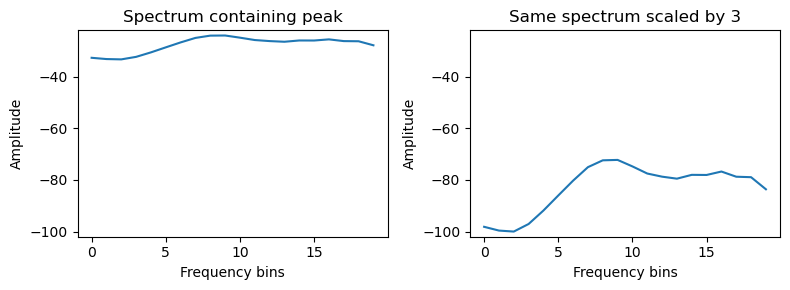

In [6]:
plt.figure(figsize=(8, 3))
y_min = min(min(inputs[7]) * 3, min(inputs[7])) - 2
y_max = max(max(inputs[7]) * 3, max(inputs[7])) + 2

# Spectrum containing a peak
plt.subplot(1, 2, 1)
plt.title('Spectrum containing peak')
plt.xlabel('Frequency bins')
plt.ylabel('Amplitude')
plt.plot(inputs[7])
plt.ylim(y_min, y_max)

# Same spectrum scaled by 3
plt.subplot(1, 2, 2)
plt.title('Same spectrum scaled by 3')
plt.xlabel('Frequency bins')
plt.ylabel('Amplitude')
plt.plot(inputs[7] * 3)
plt.ylim(y_min, y_max)

plt.tight_layout()

In [7]:
scaled = []
scaled_labels = []

for factor in np.arange(0.5, 3, step=0.1):
    for i in range(len(inputs)):
        scaled.append(inputs[i] * factor)
        scaled_labels.append(labels[i])

inputs = np.array(scaled)
labels = np.array(scaled_labels)

## Train test split
Split the dataset into `train`, `test` and `validation` set for training and evaluating the model.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
input_shape = X_train[0].shape

# Training

In [9]:
model = Sequential()

model.add(Input(shape=input_shape))
model.add(Conv1D(filters=20, kernel_size=5, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=40, kernel_size=5, activation='relu'))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [10]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 16, 20)            120       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8, 20)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 40)             4040      
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 20)                3220      
                                                                 
 dense_1 (Dense)             (None, 4)                 84        
                                                        

In [12]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=10)

Epoch 1/10
12910/12910 [==============================] - 25s 2ms/step - loss: 0.1648 - accuracy: 0.9502 - val_loss: 0.0459 - val_accuracy: 0.9852
Epoch 2/10
12910/12910 [==============================] - 26s 2ms/step - loss: 0.0343 - accuracy: 0.9900 - val_loss: 0.0335 - val_accuracy: 0.9893
Epoch 3/10
12910/12910 [==============================] - 26s 2ms/step - loss: 0.0220 - accuracy: 0.9947 - val_loss: 0.0085 - val_accuracy: 0.9991
Epoch 4/10
12910/12910 [==============================] - 27s 2ms/step - loss: 0.0188 - accuracy: 0.9962 - val_loss: 0.0319 - val_accuracy: 0.9910
Epoch 5/10
12910/12910 [==============================] - 30s 2ms/step - loss: 0.0161 - accuracy: 0.9968 - val_loss: 0.0068 - val_accuracy: 0.9992
Epoch 6/10
12910/12910 [==============================] - 28s 2ms/step - loss: 0.0176 - accuracy: 0.9966 - val_loss: 0.0070 - val_accuracy: 0.9991
Epoch 7/10
12910/12910 [==============================] - 29s 2ms/step - loss: 0.0166 - accuracy: 0.9968 - val_loss: 0

# Evaluation
The model is evaluated on `X_test`.

In [13]:
prediction = model.predict(X_test)

1594/1594 [==============================] - 2s 1ms/step


In [14]:
accuracy = accuracy_score(y_test, (prediction >= 0.5).astype(int))
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 99.85%


## Example plots
The plot below demostrates an example from the test set and prediction by the model:<br>

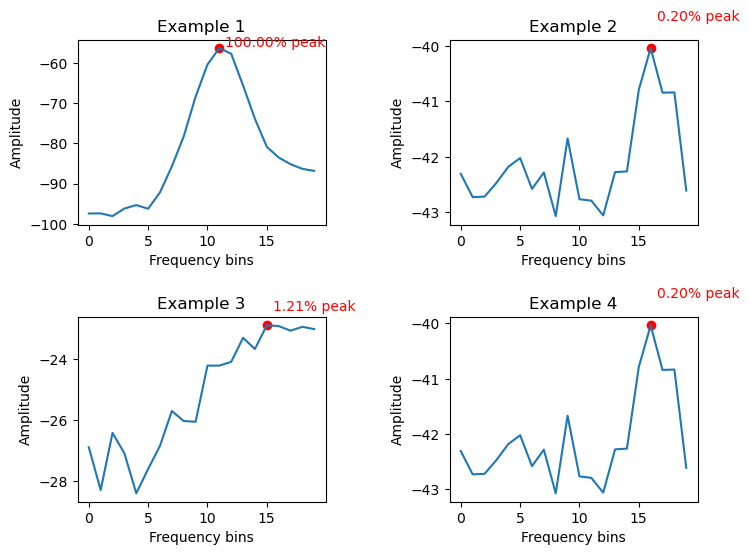

In [45]:
plt.figure(figsize=(8, 6))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# Spectrum from the test set containing a peak
peak_idx = np.argmax(X_test[69])
peak_mag = X_test[69][peak_idx]

plt.subplot(2, 2, 1)
plt.title('Example 1')
plt.xlabel('Frequency bins')
plt.ylabel('Amplitude')
plt.plot(X_test[69])
plt.scatter(peak_idx, peak_mag, c='r')
plt.text(peak_idx + 0.5, peak_mag + 0.5, f'{prediction[69, 0] * 100:.2f}% peak', c='r')

# Spectrum from the test set without a peak
peak_idx = np.argmax(X_test[94])
peak_mag = X_test[94][peak_idx]

plt.subplot(2, 2, 2)
plt.title('Example 2')
plt.xlabel('Frequency bins')
plt.ylabel('Amplitude')
plt.plot(X_test[94])
plt.scatter(peak_idx, peak_mag, c='r')
plt.text(peak_idx + 0.5, peak_mag + 0.5, f'{prediction[94, 0] * 100:.2f}% peak', c='r')

# Spectrum from the test set containing a peak
peak_idx = np.argmax(X_test[44])
peak_mag = X_test[44][peak_idx]

plt.subplot(2, 2, 3)
plt.title('Example 3')
plt.xlabel('Frequency bins')
plt.ylabel('Amplitude')
plt.plot(X_test[44])
plt.scatter(peak_idx, peak_mag, c='r')
plt.text(peak_idx + 0.5, peak_mag + 0.5, f'{prediction[44, 0] * 100:.2f}% peak', c='r')

# Spectrum from the test set without a peak
peak_idx = np.argmax(X_test[94])
peak_mag = X_test[94][peak_idx]

plt.subplot(2, 2, 4)
plt.title('Example 4')
plt.xlabel('Frequency bins')
plt.ylabel('Amplitude')
plt.plot(X_test[84])
plt.scatter(peak_idx, peak_mag, c='r')
plt.text(peak_idx + 0.5, peak_mag + 0.5, f'{prediction[94, 0] * 100:.2f}% peak', c='r')


plt.savefig('res/plot.png')

# Save the model

In [ ]:
model.save("model/model.keras")